### Author: David Hurley

### Blog: [Link](https://medium.com/@davidhurley_48402)

### GitHub: [Link](https://github.com/david-hurley)

# Notebook Objective
This notebook uses linear and tree based models to predict the sale price of homes in Ames, Iowa. The predicted sale prices are submitted to the Kaggle competition *House Prices: Advanced Regression Techniques*. 


## Overview
There are a lot of great notebooks associated with this competition, a few that I found very helpful are:
* [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models) (Alexandru Papiu)
* [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) (Serigne)

The biggest thing I have found missing in many of these notebooks is a streamlined pipeline for testing the models. This notebook focuses on doing basic EDA and using a preprocessing pipeline to process data, fit, and evaluate several models. With basic preprocessing and assumptions we can quickly obtain Root Mean Square Error (RMSE) scores that rank in the top 20%.

### Why using pipelines to do preprocessing is important?
Pipelines are great because they package your data processing and model fitting into a single package. This makes it easy to manage complex models and do feature engineering. Pipelines are even better becuase they eliminate aspects of data leakage. 

Data leakage is a major problem when developing a machine learning model. Typically, it causes a model to have seemingly high performance in the training and even validation stages. However, once the model is deployed in production (i.e. predicting unseen test data) it is likely to perform much worse than anticipated. A common cause of data leakage is Train-Test split contamination. This can occur, for example, when a preprocessing step is fit to both train and validation datasets (i.e. fitting a SimpleImpute before calling train-test split). With pipelines this can easily be avoided as perprocessing is applied independtly on the train and validation data. 

## Outline
The following sections are included in this notebook:

### A. [Load and Parse Data](#section-one)

### B. [Exploratory Data Analysis (EDA)](#section-two)
   1. [Missing Data](#section-two-a)    
   2. [Distribution of the Target Variable](#section-two-b)    
   3. [Distribution of the Numeric Feature Variable](#section-two-c)
   4. [Outliers](#section-two-d)
   5. [Categorical Feature Cardinality](#section-two-e)
    
### C. [Preprocessing](#section-three)
   1. [Initial Preprocessing](#section-three-a)
   2. [Building a Preprocessing Pipeline](#section-three-b)
       * [Define custom transformers](#section-three-b1)
       * [Define helper functions](#section-three-b2)
       * [Define Training Data](#section-three-b3)
       * [Define datatypes and encoding](#section-three-b4)
       * [Build the preprocessing pipeline](#section-three-b5)
        
### D. [Fit and Evaluate the Model](#section-four)
   1. [Cross-Validation](#section-four-a)
       * LassoCV
       * RidgeCV        
       * ElasticNetCV        
       * Random Forest        
       * XGBRegressor        
       * LGBMRegressor        
   2. [Model Stacking](#section-four-c)
    
### E. [Predict Test Dataset and Submit](#section-five)

<a id="section-one"></a>
# A. Load and Parse Data

In [125]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, FunctionTransformer, StandardScaler, OrdinalEncoder, LabelEncoder)
from sklearn.pipeline import (Pipeline, FeatureUnion)
from IPython.display import display
from sklearn.linear_model import (ElasticNet, Lasso, Ridge, LinearRegression)
from sklearn.ensemble import (RandomForestRegressor, StackingRegressor)
from xgboost import XGBRegressor
from scipy.stats import skew
from lightgbm import LGBMRegressor
from sklearn.base import TransformerMixin

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0) #  set defualt figure size

In [75]:
#  Load train and test data

df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [76]:
#  Remove any duplicate target values in the training dataset

if len(set(df_train.Id)) == len(df_train):
    print('There are no duplicates of the target variable')
else:
    df_train.drop_duplicates(subset=['Id'], inplace=True)
    
#  Create new variable test_id and remove Id from train and test data as it says nothing about sale price

test_id = df_test.Id
df_train.drop(columns=['Id'], inplace=True)
df_test.drop(columns=['Id'], inplace=True)

There are no duplicates of the target variable


<a id="section-two"></a>
# B. Exploratory Data Analysis (EDA)
The purpose of EDA is to get familiar with our data, but not so familiar that we begin making assumptions about the model fit! In Kaggle competitions it can be tempting to overfit the training data in hopes of a lower test score, but this often doesn't bode well for real world applications. Typically, it's best to let the data speak for itself and allow the model the flexibility to find correlations between the target and features. Afterall, the models in todays age are very robust. 

### Do Preprocessing Later!
This is really more of a personal opinion. I find it hard to keep track of data processing done in cells throughout an EDA section. Typically, I prefer to do all the preprocessing in a single code block or even better in a pipeline. This way I know the preprocessing is being applied the same way to the train, validation, and test datasets. I use EDA as a way to identify the preprocessing steps that need to take place and potential feature engineering opportunities. 

Remember, it's best to do preprocessing in a pipeline!!!

In this section I will explore the following common issues:
1. Missing Data
2. Distribution of the Target Variable
3. Distribution of the Feature Variables
4. Outliers
5. Categorical Feature Cardinality

<a id="section-two-a"></a>
### 1. Missing Data

##### A few things to note here:
* Most of the missing data is associated with categorical features (16 categorical features with missing data and only 3 numeric)
* A few features have more than 50% missing data (i.e. Pool Quality)
* Some features have almost no valid data (i.e. Pool Quality)

### IMPORTANT
Upon further investigation of the *data_description.txt* it seems that 'NA' for cateogrical data represents 'No' (i.e. no garage) and is not an indicator of missing data. When we read in the data with Pandas it automatically flags 'NA' and converts to 'NaN'. We will need to address this later on in the preprocessing pipeline by replacing missing values in categroical data with 'None' or something equivalent. Afterall, this is useful data! 

Number of numerical features with missing data: 3
Number of categorical features with missing data: 16


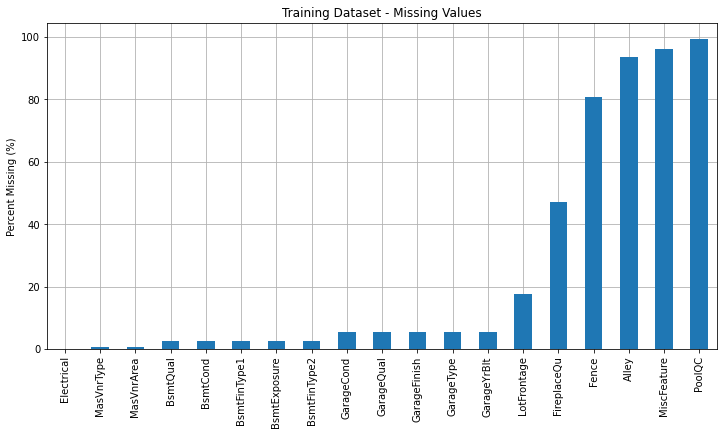

In [77]:
#  Calculate percent missing data in train dataset
missing = df_train.isnull().sum()
missing = missing[missing > 0] / len(df_train) * 100

#  Sort data
missing.sort_values(inplace=True)

#  Create bar plot
missing.plot.bar(zorder=2)
plt.title('Training Dataset - Missing Values')
plt.ylabel('Percent Missing (%)')
plt.grid(zorder=0)

#  Print number of categorical and numeric features with missing data
num_cols = df_train.select_dtypes(exclude='object').columns
cat_cols = df_train.select_dtypes('object').columns

num_missing = len(df_train[num_cols].columns[df_train[num_cols].isnull().any()])
cat_missing = len(df_train[cat_cols].columns[df_train[cat_cols].isnull().any()])

print(f"Number of numerical features with missing data: {num_missing}")
print(f"Number of categorical features with missing data: {cat_missing}")

<a id="section-two-b"></a>
### 2. Distribution of the Target Variable

##### A few things to note here:
* Sale Price is positively skewed
* Taking the Log of sale price we can normalize the distribution

We are going to use linear and tree based models to predict sale price. Tree based models don't assume normally distributed variables but linear models do. We see that Sale Price is not normally distributed, it's positively skewed. We should use the Log of sale price to obtain a more normal distribution. 

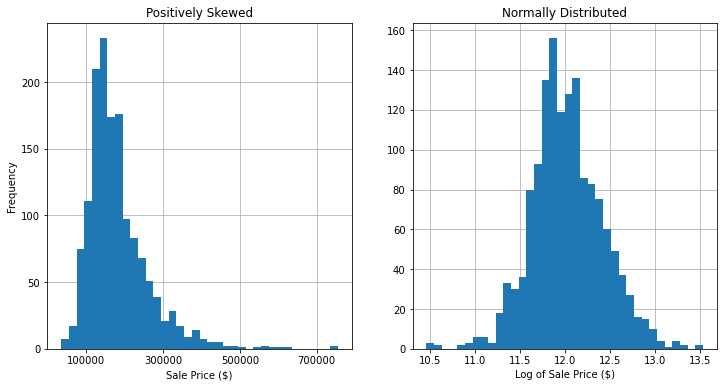

In [78]:
#  Plot distribution of sale price in training dataset
f, axs = plt.subplots(1,2)
axs[0].hist(df_train.SalePrice, bins=36, zorder=2)
axs[0].set_title('Positively Skewed')
axs[0].set_xlabel('Sale Price ($)')
axs[0].set_ylabel('Frequency')
axs[0].set_xticks(ticks=[1e5, 3e5, 5e5, 7e5])
axs[0].grid(zorder=0)

#  Plot distribution of log of sale price in training dataset
axs[1].hist(np.log(df_train.SalePrice), bins=36, zorder=2)
axs[1].set_title('Normally Distributed')
axs[1].set_xlabel('Log of Sale Price ($)')
axs[1].grid(zorder=0)

<a id="section-two-c"></a>
### 3. Distribution of the Numeric Feature Variables

##### A few things to note here:
* Some of the numeric features are continous (i.e. square footage features) while some are discrete (i.e. # of baths/rooms)
* None of the features display much of a normal distribution
* The discrete features represent metrics like *# of rooms* and *year sold*.

As with the target we should check that the numeric features are roughly normally distributed. We see that all of the features have some amount of skew and we will want to reduce this skew before fitting our models. Additionally, we see that the range of values is all over. We can make the ranges more similar by using a standard scalar to remove the mean and scaling to unit variance.

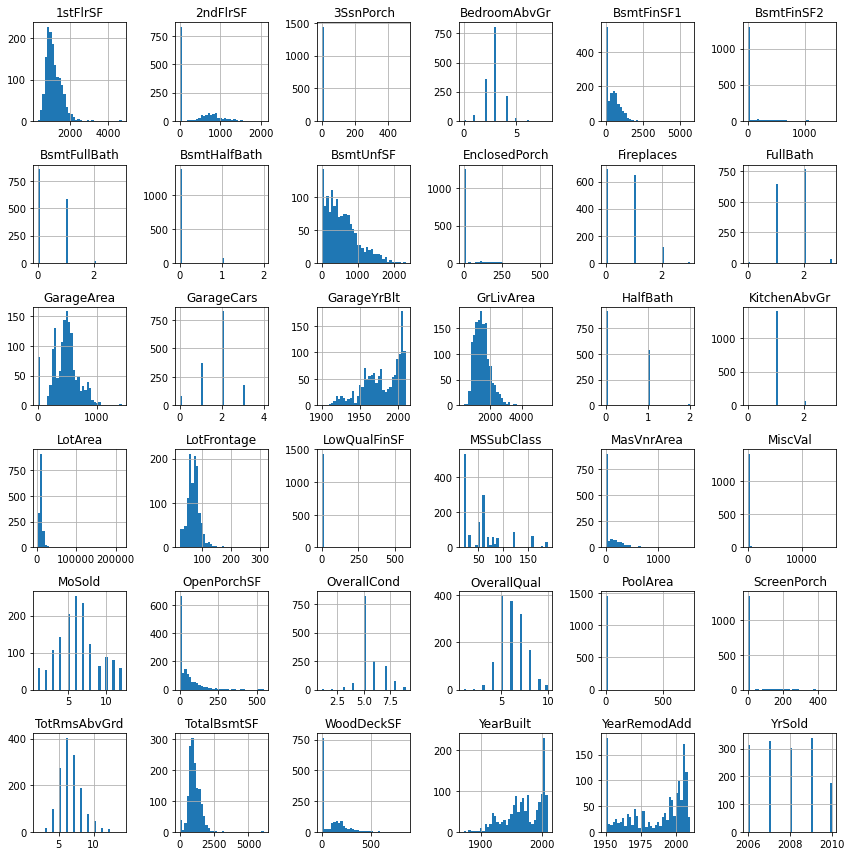

In [79]:
#  Only numeric columns and features (i.e. no sale price)
num_cols = list(df_train.select_dtypes(exclude='object').columns)
num_cols.remove('SalePrice')

#  Plot all feature data
df_train[num_cols].hist(bins=36, figsize=(12,12))
plt.tight_layout()

<a id="section-two-d"></a>
### 4. Outliers

##### A few things to note here:
* There are two distinct outliers that have huge square footage but cheap prices
* If we leave these then are linear models won't work very well


Typically it's not great practice to remove outliers unless you have domain knowledge for whey they are being removed. We can picture the relation between Sale Price and Above Ground Square Footage pretty easily (larger house --> larger price). 

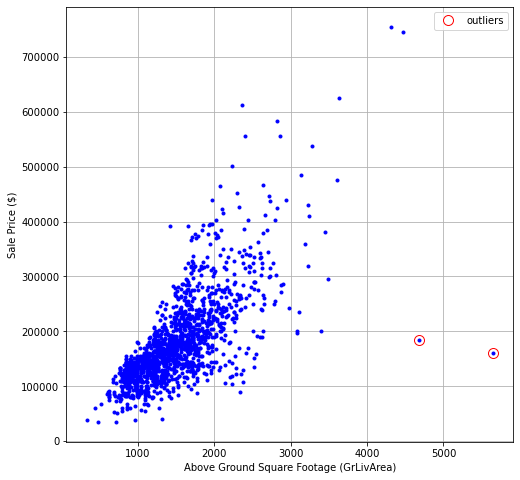

In [80]:
#  Find outliers

outliers = df_train.loc[(df_train.SalePrice < 200000) & (df_train.GrLivArea > 4000)]

#  Plot Sale Price against Above Ground Square Footage

plt.figure(figsize=(8,8))

plt.plot(df_train.GrLivArea, df_train.SalePrice,'b.')
plt.plot(outliers.GrLivArea, outliers.SalePrice, 'ro', markerfacecolor='none', markersize=10, label='outliers')
plt.xlabel('Above Ground Square Footage (GrLivArea)')
plt.ylabel('Sale Price ($)')
plt.legend()
plt.grid()

#  Drop outliers from training data
df_train.drop(outliers.index, inplace=True)

<a id="section-two-e"></a>
### 5. Categorical Feature Cardinality

##### A few things to note here:
* Most categorical features have fewer than 10 unique values
* A few categorical features have greater than 15 unique values
* In general we should be fine with One Hot Encoding without overloading our matrix dimensions

When we build our preprocessing pipeline we will need to encode categorical features with OneHot Encoding.

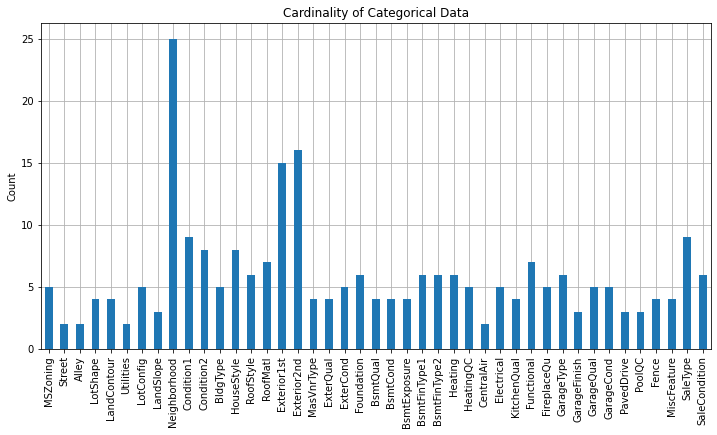

In [81]:
#  Plot cardinality of categorical columns

cat_cols = df_train.select_dtypes('object').columns

df_train[cat_cols].nunique().plot.bar(zorder=2)
plt.ylabel('Count')
plt.title('Cardinality of Categorical Data')
plt.grid(zorder=0)

<a id="section-three"></a>
# C. Preprocessing

Now that we have done some initial EDA we should preprocess the data based on the findings. I prefer to group preprocessing steps together as I find it's easier to "stack trace" any problems. 

In this section I will do the following:
* Apply initial preprocessing
* Build a preprocessing pipeline

We are not going to be very advanced and will address the following issues that we identified in EDA:
1. Remove outliers
2. Transform Sale Price to Log of Sale Price
3. Replace missing values in numeric features with the *mean*
4. Add a feature for Total Square Footage
5. Transform numeric features to Log of numeric features
6. Replace missing values in categorical features with 'None'
7. OneHot Encode categorical features
8. Standarize all features

<a id="section-three-a"></a>
### 1. Initial Preprocessing

Lets remove the identified outliers from the training dataset and take the log of the target variable to obtain a more normal distribution. Notice that these steps are specific to the training dataset and won't be applied to the test dataset. Anything that is done to both the training and test datasets will be done in our preprocessing pipeline. 

In [82]:
#  Remove outliers from training dataset

outliers = df_train.loc[(df_train.SalePrice < 200000) & (df_train.GrLivArea > 4000)]
df_train.drop(outliers.index, inplace=True)

#  Use log of sale price in training dataset

df_train.SalePrice = np.log(df_train.SalePrice)

<a id="section-three-b"></a>
### 2. Building a Preprocessing Pipeline

Pipelines are a way to prevent train-test split contamination, keep models organized, and easily assess the performance of hyperparameter tuning and feature engineering. Additionally, if you are going to deploy models in production, such as on a cloud based server, this keeps everything organized and traceable. 

**In this section I will do the following:**
1. Define custom transformer classes to be included in the pipeline
2. Define custom helper functions to compute Root Mean Square Error (RMSE)
3. Split the training and test data
4. Define numeric and categorical features
3. Build the pipeline

<a id="section-three-b1"></a>
### Define Custom Transformers

Scikit-learn has great built-in classes for data preprocessing, like imputing missing values and normalizing features. However, sometimes we want to add preprocessing steps that don't exist or modify an existing transformers behaviour (i.e. have the output of SimpleImputer be a dataframe). We can accomplish this by defining our own custom transformers.

In [83]:
#  Custom transformer to extract specific features
    
class ColumnExtractor(TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xcols = X[self.cols]
        return Xcols

#  Custom transformer to convert numerical features to categorical

class NumericToCategorical(TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xchg = X.copy()
        Xchg.loc[:,self.cols] = Xchg[self.cols].astype('str')
        return Xchg
    
#  Custom transformer that inherits from SimpleImputer class and returns a dataframe

class DFSimpleImputer(SimpleImputer):
    
    def transform(self, X):
        Xim = super(DFSimpleImputer, self).transform(X)
        Xim = pd.DataFrame(Xim, index=X.index, columns=X.columns)
        return Xim
    
#  Custom transformer that inherits from OneHotEncoder and return a dataframe
    
class DFOneHotEncoder(OneHotEncoder):
    
    def transform(self, X):
        Xoh = super(DFOneHotEncoder, self).transform(X)
        Xoh = pd.DataFrame(Xoh, X.index)
        return Xoh

#  Custom transformer that creates a new feature TotalSquareFootage

class TotalSF(TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xadd = X.copy()
        Xadd['TotalSF'] = Xadd.GrLivArea + Xadd.TotalBsmtSF + Xadd.GarageArea
        return Xadd

<a id="section-three-b2"></a>
### Define Helper Functions

Lets create a helper function that will use Cross-Validaton to evauluate the average Root Mean Square Error (RMSE) over X folds. This is useful as it gives us a more robust score of our model predictions on the training dataset. 

In [84]:
#  Helper function that computes the average RMSE over X folds using Cross-Validation. Cross-Validation function will fit and score data.

def get_RMSE(pipeline, X, y, folds):

    MSE_scores = -1 * cross_val_score(pipeline, X, y, cv=folds, scoring='neg_mean_squared_error')
    RMSE_scores = np.sqrt(MSE_scores)
    
    return RMSE_scores

<a id="section-three-b3"></a>
### Define Training and Testing Data

Define training data to run through cross-validation and hyperparameter tuning and test data to sumbit prediction to Kaggle

In [85]:
#  Training and testing datasets

X_train = df_train.drop(columns=['SalePrice'])
y_train = df_train.SalePrice
X_test = df_test

<a id="section-three-b4"></a>
### Define Data Types and Encoding

In [86]:
#  Numerical features

numeric_columns = X_train.select_dtypes(exclude='object').columns

#  Categorical features

categorical_columns = X_train.select_dtypes('object').columns

<a id="section-three-b5"></a>
### Build the Preprocessing Pipeline!

In [87]:
#  Define the preprocessing pipeline

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('numeric', Pipeline([
            ('extract', ColumnExtractor(numeric_columns)),
            ('imputer', DFSimpleImputer()),
            ('totalSF', TotalSF()), #  create a new feature total square footage
            ('logger', FunctionTransformer(np.log1p)) #  take the log of all numeric features to create a normal distribution
        ])),
        ('categorical', Pipeline([
            ('extract', ColumnExtractor(categorical_columns)),
            ('imputer', DFSimpleImputer(strategy='constant', fill_value='None')), #  we determined earlier that 'NA' for categorical really means 'None'
            ('encode', DFOneHotEncoder(handle_unknown='ignore', sparse=False))
        ])),
    ])),
    ('scale', StandardScaler())  #  scale all features
])

<a id="section-four"></a>
# D. Fit and Evauluate the Models

Now that we have defined a preprocessing pipeline we can fit a range of models and evaluate using our scoring metric. I am going to use Cross-Validation to get a more robust score and compare each model.

**The following models are going to be fit using the default hyperparameters:**
* LassoCV (Cross-Validation is incorporated in the algorithim so we will have nested cross-validation)
* RidgeCV (same as LassoCV)
* ElasticNetCV (same as LassoCV)
* Random Forest
* XGBoost
* LGBMRegressor

**Amazingly, with very little data preperation and using basic linear models we can quickly get a training score that would put us in the top 20% of the leaderboard.**

<a id="section-four-a"></a>
### 1. Cross Validation

RMSE Cross-Validation Training Scores 

LassoCV Training Score: 0.1116
RidgeCV Training Score: 0.1242
ElasticNetCV Training Score: 0.1115
RandomForestRegressor Training Score: 0.1328
XGBRegressor Training Score: 0.1329
LGBMRegressor Training Score: 0.1238


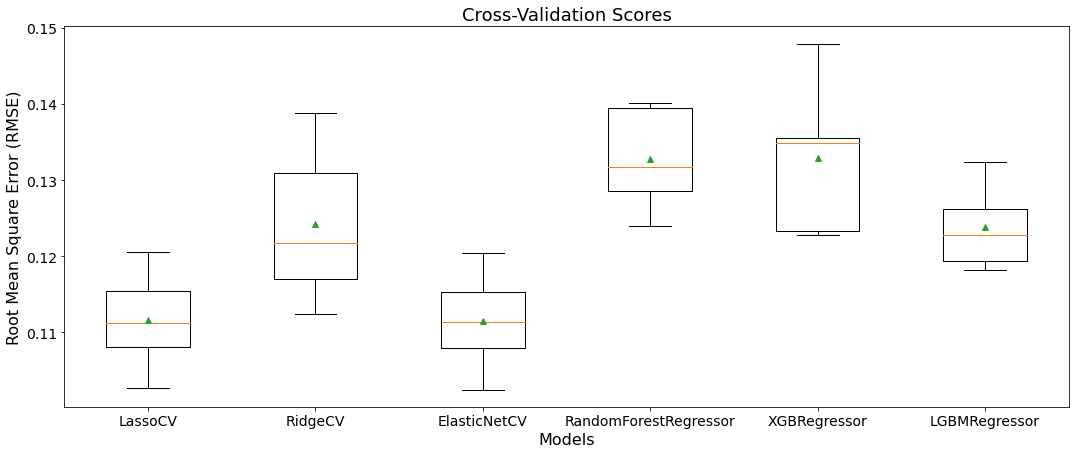

In [110]:
#  Define the models to fit and evaluate.

models = [
    LassoCV(),
    RidgeCV(),
    ElasticNetCV(),
    RandomForestRegressor(),
    XGBRegressor(), 
    LGBMRegressor()
]

#  Preprocess the data for each model, fit the model, and evaluate

print('RMSE Cross-Validation Training Scores \n')

RMSE = []
model_names = []
for i, model in enumerate(models):
    
    full_pipeline = Pipeline(steps=[('pipeline', pipeline),
                                    ('model', model)])

    #  Fit training data and score
    
    RMSE.append(get_RMSE(full_pipeline, X_train, y_train, 5))
    
    #  Print the scores
    
    model_names.append(str(model).split('(')[0])
    print('{} Training Score: {}'.format(model_names[i], round(np.mean(RMSE[i]),4)))
    
#  Create a boxplot of the scores

plt.figure(figsize=(18,7))
plt.boxplot(RMSE, labels=model_names, showmeans=True)
plt.xlabel('Models', fontsize=16)
plt.ylabel('Root Mean Square Error (RMSE)', fontsize=16)
plt.title('Cross-Validation Scores', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'both', which = 'minor', labelsize = 14)

x = '' #  Hack to stop figure vomit

<a id="section-four-c"></a>
### 2. Model Stacking

Many times a model may perform well on certain aspects of a dataset and worse on others. This can make it challening to choose one model over another. Instead we can create a stacked ensemble of models that takes advantage of each models "strengths". 

RMSE Cross-Validation Training Scores With Stacked Model 

LassoCV Training Score: 0.1116
RidgeCV Training Score: 0.1242
ElasticNetCV Training Score: 0.1115
RandomForestRegressor Training Score: 0.1337
XGBRegressor Training Score: 0.1329
LGBMRegressor Training Score: 0.1238


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016067179995952863, tolerance: 0.011717217049894426
  tol, rng, random, positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014543712329581737, tolerance: 0.011670405015620233
  tol, rng, random, positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01206219541263387, tolerance: 0.011932241359150771
  tol, rng, random, positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You mig

StackingRegressor Training Score: 0.1095


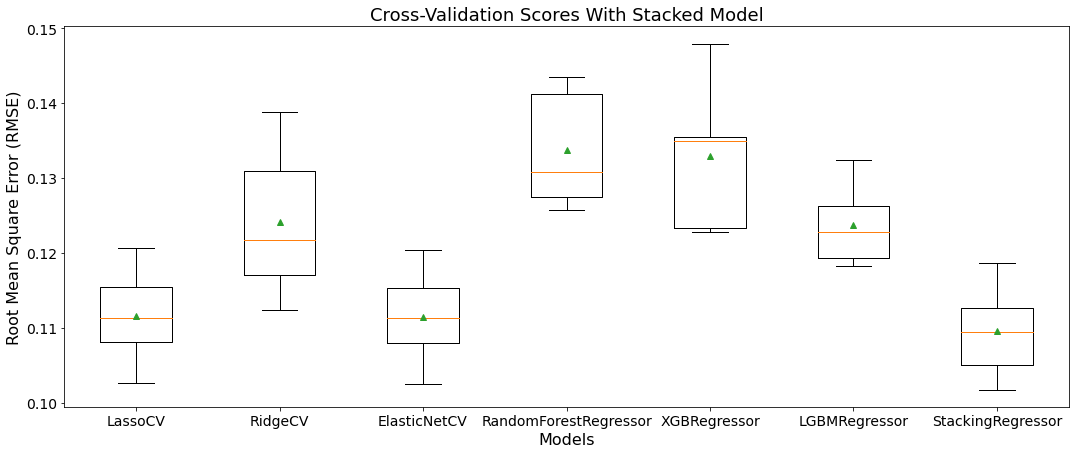

In [111]:
#  Define models that we want to stack

models = [
    LassoCV(),
    RidgeCV(),
    ElasticNetCV(),
    RandomForestRegressor(),
    XGBRegressor(), 
    LGBMRegressor()
]

#  Define estimators to stacked regressor
estimator_names = ['lassoCV', 'ridgeCV', 'elasticnetCV', 'random_forest', 'xgbregressor', 'lgbmregressor']
estimators = [(estimator_names[i], model) for i, model in enumerate(models)]
    
#  Define stacked model with Linear Regression as the final estimator
Stacked = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(tol=0.001), cv=5)

#  Add stacked model to models list from previous step
models.append(Stacked)

#  Preprocess the data for each model, fit the model, and evaluate

print('RMSE Cross-Validation Training Scores With Stacked Model \n')

RMSE = []
model_names = []
for i, model in enumerate(models):
    
    full_pipeline = Pipeline(steps=[('pipeline', pipeline),
                                    ('model', model)])

    #  Fit training data and score
    RMSE.append(get_RMSE(full_pipeline, X_train, y_train, 5))
    
    model_names.append(str(model).split('(')[0])
    print('{} Training Score: {}'.format(model_names[i], round(np.mean(RMSE[i]),4)))
    
#  Create a boxplot of the scores
plt.figure(figsize=(18,7))
plt.boxplot(RMSE, labels=model_names, showmeans=True)
plt.xlabel('Models', fontsize=16)
plt.ylabel('Root Mean Square Error (RMSE)', fontsize=16)
plt.title('Cross-Validation Scores With Stacked Model', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'both', which = 'minor', labelsize = 14)

x = '' #  Hack to stop figure vomit

<a id="section-five"></a>
# E. Predict the Test Dataset and Submit

Let's submit our predictions! Before we do we should retrain using the entire training dataset so that we squeeze out a bit more performance. Look how easy this is with pipelines!

In [ ]:
#  Preprocess and fit entire training dataset

full_pipeline = Pipeline(steps=[('pipeline', pipeline),
                                ('model', Stacked)])

full_pipeline.fit(X_train, y_train) #  fit to entire training dataset and not just K folds of it

#  Predict the test dataset target values

y_predict = full_pipeline.predict(df_test)
y_predict = np.expm1(y_predict)  #  Kaggle will take the log of sale price to compare

my_submission = pd.DataFrame({'Id': test_id, 'SalePrice': y_predict})
my_submission.to_csv('submission.csv', index=False)